In [1]:
import sys
sys.path.append("..")

import Essentials


In [2]:
import numpy as np
import pandas as pd
import Visualizer_pred
from sklearn.preprocessing import StandardScaler
import Essentials
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score
from abc import ABC, abstractmethod

In [3]:
data_archive = np.load('C:\\Users\\misha\\Makarov\\Data_First_Nikita.npz', allow_pickle=True)

In [4]:
def prepare_Y(y):
    timestamp = y[:, 1]
    y = y[:, 0].reshape(len(y), 1)
    y = y.astype(np.float64)

    return y, timestamp

ALL_column_names_1 = data_archive['column_names_1']
all_X_1 = data_archive['all_X_1']
all_Y_1 = data_archive['all_Y_1']

ALL_column_names_2 = data_archive['column_names_2_cat']
all_X_2 = data_archive['all_X_2']
all_Y_2 = data_archive['all_Y_2']

ALL_column_names_3 = data_archive['column_names_3_cat']
all_X_3 = data_archive['all_X_3']
all_Y_3 = data_archive['all_Y_3']

column_names_2 = data_archive['column_names_2']
x_summer_half_2 = data_archive['x_summer_half_2']
y_summer_half_2 = data_archive['y_summer_half_2']
x_winter_half_2 = data_archive['x_winter_half_2']
y_winter_half_2 = data_archive['y_winter_half_2']

column_names_3 = data_archive['column_names_3']
x_summer_half_3 = data_archive['x_summer_half_3']
y_summer_half_3 = data_archive['y_summer_half_3']
x_winter_half_3 = data_archive['x_winter_half_3']
y_winter_half_3 = data_archive['y_winter_half_3']

df_X1 = pd.read_csv(r'../raw_X1.csv', index_col=0)
df_X2 = pd.read_csv(r'../raw_X2.csv', index_col=0)
df_X3 = pd.read_csv(r'../raw_X3.csv', index_col=0)
df_Y1 = pd.read_csv(r'../raw_Y1.csv', index_col=0)
df_Y2 = pd.read_csv(r'../raw_Y1.csv', index_col=0)
df_Y3 = pd.read_csv(r'../raw_Y1.csv', index_col=0)

x_train, x_test, y_train, y_test=train_test_split(all_X_1, all_Y_1, test_size=0.2, random_state=42)

y_train, timestamp_train = prepare_Y(y_train)
sorted_indices_train = np.argsort(timestamp_train)
y_train = y_train[sorted_indices_train]
timestamp_train = timestamp_train[sorted_indices_train]
x_train = x_train[sorted_indices_train]

y_test, timestamp_test = prepare_Y(y_test)

x_test1, x_val, y_test1, y_val, timestamp_test1, timestamp_val = train_test_split(
    x_test, y_test, timestamp_test, test_size=0.5, random_state=42
)

sorted_indices_test = np.argsort(timestamp_test)
y_test = y_test[sorted_indices_test]
timestamp_test = timestamp_test[sorted_indices_test]
x_test = x_test[sorted_indices_test]

print(all_X_1.shape)
print(all_Y_1.shape)
print(x_train.shape)
print(y_test.shape)

x_train_winter, x_test_winter, y_train_winter, y_test_winter = train_test_split(x_winter_half_3, y_winter_half_3, test_size=0.2, random_state=42)
x_train_summer, x_test_summer, y_train_summer, y_test_summer = train_test_split(x_summer_half_3, y_summer_half_3, test_size=0.2, random_state=42)

y_train_summer, timestamp_train_summer = prepare_Y(y_train_summer)
sorted_indices_train_summer = np.argsort(timestamp_train_summer)
y_train_summer = y_train_summer[sorted_indices_train_summer]
timestamp_train_summer = timestamp_train_summer[sorted_indices_train_summer]
x_train_summer = x_train_summer[sorted_indices_train_summer]

y_train_winter, timestamp_train_winter = prepare_Y(y_train_winter)
sorted_indices_train_winter = np.argsort(timestamp_train_winter)
y_train_winter = y_train_winter[sorted_indices_train_winter]
timestamp_train_winter = timestamp_train_winter[sorted_indices_train_winter]
x_train_winter = x_train_winter[sorted_indices_train_winter]

y_test_summer, timestamp_test_summer = prepare_Y(y_test_summer)
sorted_indices_test_summer = np.argsort(timestamp_test_summer)
y_test_summer = y_test_summer[sorted_indices_test_summer]
timestamp_test_summer = timestamp_test_summer[sorted_indices_test_summer]
x_test_summer = x_test_summer[sorted_indices_test_summer]

y_test_winter, timestamp_test_winter = prepare_Y(y_test_winter)
sorted_indices_test_winter = np.argsort(timestamp_test_winter)
y_test_winter = y_test_winter[sorted_indices_test_winter]
timestamp_test_winter = timestamp_test_winter[sorted_indices_test_winter]
x_test_winter = x_test_winter[sorted_indices_test_winter]

column_names_X1 = df_X1.columns.tolist()
column_names_X2 = df_X2.columns.tolist()
column_names_X3 = df_X3.columns.tolist()
column_name_Y1 = 'Давление насыщенных паров в зимний период'
column_name_Y2 = 'Конец кипения легкого бензина'
column_name_Y3 = 'Содержание олефинов в продукте'

column_names_X1.pop()
column_names_X2.pop()
column_names_X3.pop()

feature_names_1 = column_names_X1
feature_names_2 = column_names_X2
feature_names_3 = column_names_X3

target_name_1 = column_name_Y1
target_name_2 = column_name_Y2
target_name_3 = column_name_Y3


(107, 87)
(107, 2)
(85, 87)
(22, 1)


In [5]:

class PLSSVDSoftSensor(Essentials.SoftSensor):
    def __init__(self, name, x_train, y_train, x_test, y_test, column_names, max_components=10):
        super().__init__(name)
        self.column_names = column_names
        self.r2_score = None
        self.best_n_components = None
        self.best_model = None
        self.train(x_train, y_train, x_test, y_test, max_components)

    def preprocessing(self, x):
        return x

    def postprocessing(self, y):
        return y

    def evaluate_model(self, x):
        return self.get_model().predict(x)

    def train(self, x_train, y_train, x_test, y_test, max_components):
        best_score = -np.inf
        best_n_components = 0

        for i in range(1, max_components + 1):
            model = PLSRegression(n_components=i, scale=False)
            model.fit(x_train, y_train)
            score = r2_score(y_test, model.predict(x_test))
            if score > best_score:
                best_score = score
                best_n_components = i
                self.best_model = model

        self.set_model(self.best_model)
        self.best_n_components = best_n_components
        self.r2_score = best_score

    def __str__(self):
        if self.get_model() is not None:
            # Находим длину самого длинного названия признака для выравнивания
            max_len = max(len(name) for name in self.column_names)
            
            # Подготавливаем строки коэффициентов с названиями признаков и выравниванием
            coefs_str = "\n".join(
                [f"{name.ljust(max_len)}: {coef:.4f}" for name, coef in zip(self.column_names, self.get_model().coef_.flatten())]
            )
            
            return (
                f"Модель PLSSVD с {self.best_n_components} компонентами: \n"
                f"Коэффициенты:\n{coefs_str} \n"  # Коэффициенты выводятся строкой с выравниванием
                f"R^2 (тестовая выборка): {self.r2_score:.4f}"  # Форматирование R^2 до 4 знаков после запятой
            )
        else:
            return "Модель PLSSVD еще не обучена."



In [6]:
Test_sensor_1 = PLSSVDSoftSensor("PLS Sensor", x_train, y_train, x_test, y_test, column_names= ALL_column_names_1, max_components=86)

In [7]:
print(Test_sensor_1)

Модель PLSSVD с 15 компонентами: 
Коэффициенты:
Расход бензина ККР на установку           : -0.0752
Расход нафты ККР на установку             : -0.0098
Расход бензина на рециркуляцию от Е-1205  : -0.0635
Температура бензина ККР на установку      : -0.0267
Расход сырья после Р-1101                 : 0.2470
Показатель соотношения водород к углероду : -0.0175
Расход водорода на смешение перед Е-1101  : -0.0233
Температура сырья перед Е-1101            : 0.0878
Давление сырья перед Е-1101               : -0.0088
Температура сырья перед Е-1102            : -0.1634
Температура сырья перед Е-1103            : 0.0878
Давление сырья перед Е-1103               : -0.0084
Температура сырья после Е-1103            : 0.1481
Температура ТБ перед Е-1101               : 0.1119
Температура ТБ после Е-1101               : -0.0973
Температура бензина перед Е-1102          : 0.1455
Температура бензина после Е-1102          : 0.0314
Давление бензина после Е-1102             : -0.0271
Температура пара перед 

In [8]:
metric = Essentials.R2Metric()

In [9]:
test_visual = Essentials.Visualizer(x_train, y_train, timestamp_train, [metric], 'Test SoftSensor R2 metric')

            Coefficient of determination
PLS Sensor                      0.858033


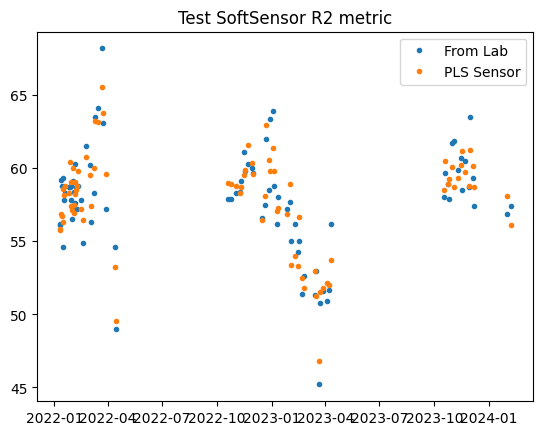

In [10]:
test_visual.visualize([Test_sensor_1])

+------------+--------------------------------+--------+
|            |   Coefficient of determination |    MSE |
+============+================================+========+
| PLS Sensor |                       0.835277 | 2.0328 |
+------------+--------------------------------+--------+


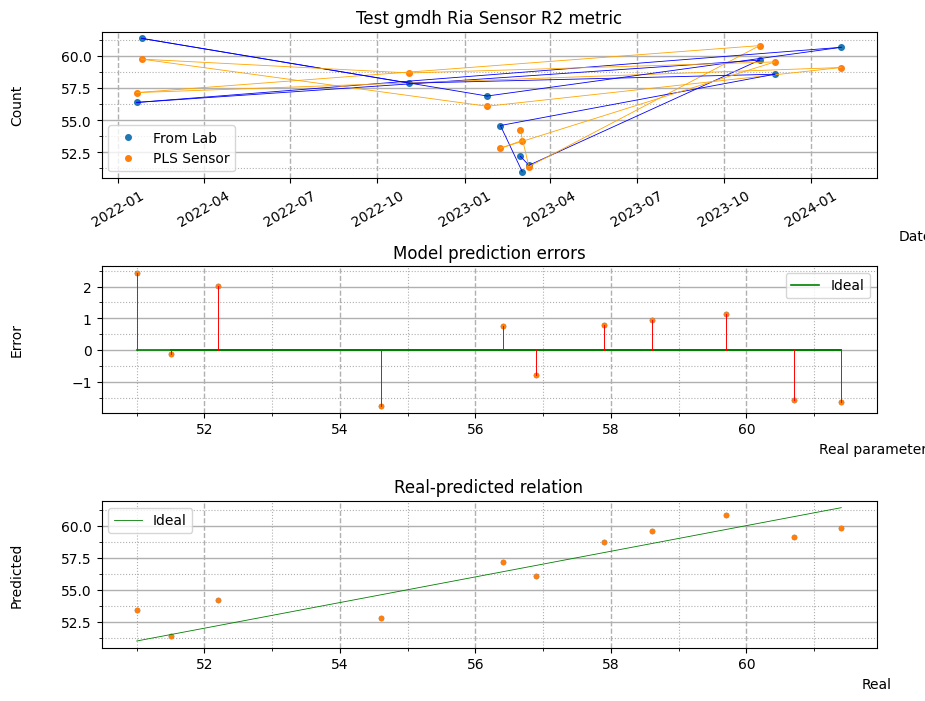

In [11]:
test_visual=Visualizer_pred.Visualizer(x_val, y_val, timestamp_val,[metric], 'Test gmdh Ria Sensor R2 metric')
test_visual.visualize([Test_sensor_1], lines=True, lines_vertical=True)

+------------+--------------------------------+-------+
|            |   Coefficient of determination |   MSE |
+============+================================+=======+
| PLS Sensor |                       0.807084 | 2.139 |
+------------+--------------------------------+-------+


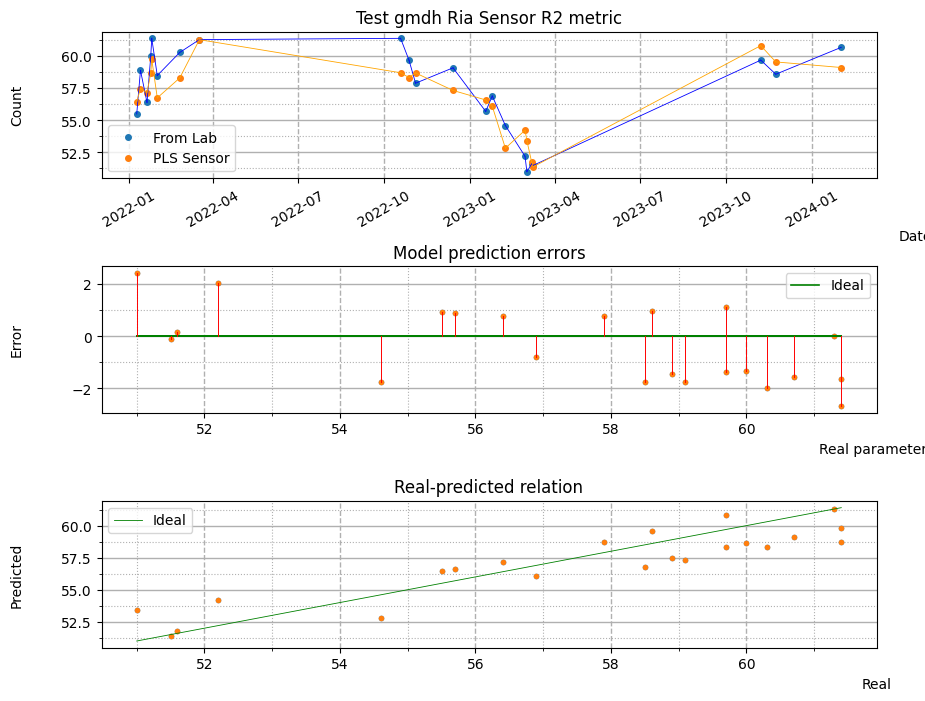

In [12]:
test_visual=Visualizer_pred.Visualizer(x_test, y_test, timestamp_test,[metric], 'Test gmdh Ria Sensor R2 metric')
test_visual.visualize([Test_sensor_1], lines=True, lines_vertical=True)